# Stratification v2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [8]:
import numpy as np
import statsmodels.formula.api as smf

import numpy as np
from tqdm import tqdm


def bootstrap(df, function, n=50, ci=95, set_seed=True, **kwargs):
    """
    Perform bootstrap resampling to estimate the confidence interval of a statistic.

    Parameters:
    - df (pd.DataFrame): The dataset to resample from.
    - function (callable): The function to apply to each resampled dataset. It should take the DataFrame
                           as its first argument and any additional keyword arguments.
    - n (int): The number of bootstrap samples to draw. Default is 50.
    - ci (int): The desired confidence interval percentage. Default is 95.
    - set_seed (bool): Whether to set a random seed for reproducibility. Default is True.
    - **kwargs: Additional keyword arguments to pass to the function.

    Returns:
    - numpy.ndarray: An array containing the mean, lower confidence interval, and upper confidence interval.
    """
    if set_seed:
        np.random.seed(42)
    results = []

    for _ in range(n):
        # this will ensure our bootstrapped sample is the same length
        # with replacement: https://en.wikipedia.org/wiki/Bootstrapping_(statistics)
        new_df = df.sample(n=df.shape[0], replace=True)
        assert new_df.shape == df.shape  # same shape
        results.append(function(new_df, **kwargs))

    # CI calculations: https://statisticsbyjim.com/hypothesis-testing/bootstrapping/
    # E.g. 95% CI is 2.5% - 97.5%
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile

    results_arr = np.array(results)
    lower_ci = np.percentile(results_arr, lower_percentile, axis=0)
    upper_ci = np.percentile(results_arr, upper_percentile, axis=0)
    mean_ = np.mean(results_arr)

    return np.array([mean_, lower_ci, upper_ci])


def bootstrap_experiment(df, function, num_exp=10, n=50, ci=95, **kwargs):
    """
    Conduct multiple bootstrap experiments to estimate the variability of the bootstrap estimates.

    Parameters:
    - df (pd.DataFrame): The dataset to resample from.
    - function (callable): The function to apply to each resampled dataset. It should take the DataFrame
                           as its first argument and any additional keyword arguments.
    - num_exp (int): The number of bootstrap experiments to run. Default is 10.
    - n (int): The number of bootstrap samples to draw in each experiment. Default is 50.
    - ci (int): The desired confidence interval percentage. Default is 95.
    - **kwargs: Additional keyword arguments to pass to the function.

    Returns:
    - numpy.ndarray: An array containing the bootstrap results for each experiment.
    """
    experiment_results = []

    for _ in tqdm(range(num_exp), desc=f"Running experiments"):
        ci_result = bootstrap(df, function, n=n, ci=ci, set_seed=False, **kwargs)
        experiment_results.append(ci_result)

    return np.array(experiment_results)

def ipw(df, treatment_col, outcome_col, confounder_cols):
    """
    Estimate the causal effect of the treatment on the outcome using Inverse
    Probability Weighting (IPW).

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment, outcome, and
    confounder columns.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - effect (float): The estimated causal effect of the treatment on the outcome.
    """
    df_copy = df.copy()
    results = []
    treatments = sorted(np.unique(df_copy[treatment_col]))

    formula = f"{treatment_col} ~ " + " + ".join(confounder_cols)
    model = smf.mnlogit(formula=formula, data=df_copy).fit(disp=False)

    propensity_scores = model.predict(df_copy).reset_index(drop=True)
    df_copy["propensity"] = df_copy.apply(
        lambda row: propensity_scores.loc[row.name, int(row[treatment_col])], axis=1
    )
    df_copy["ipw"] = 1 / df_copy["propensity"]

    for a_val in treatments:
        df_a = df_copy.loc[df_copy[treatment_col] == a_val, :].reset_index(drop=True)
        weighted_mean = np.average(df_a[outcome_col], weights=df_a["ipw"])
        results.append(weighted_mean)

    return results[1] - results[0]


def prop_probs(df, treatment_col, confounder_cols):
    """
    Calculate propensity scores for each observation in the dataset.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment and confounder
    columns.
    - treatment_col (str): The name of the treatment column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - pd.DataFrame: A DataFrame containing the original data with an additional
    column for propensity scores.
    """
    df_copy = df.copy()

    formula = f"{treatment_col} ~ " + " + ".join(confounder_cols)
    model = smf.mnlogit(formula=formula, data=df_copy).fit(disp=False)

    propensity_scores = model.predict(df_copy).reset_index(drop=True)
    df_copy["propensity"] = df_copy.apply(
        lambda row: propensity_scores.loc[row.name, int(row[treatment_col])], axis=1
    )
    return df_copy[["id", "propensity"]]


def ipw_probs(df, treatment_col, confounder_cols):
    """
    Calculate inverse probability weights (IPW) for each observation in the dataset.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment and confounder
    columns.
    - treatment_col (str): The name of the treatment column.
    - confounder_cols (list of str): A list of names of confounder columns.

    Returns:
    - pd.DataFrame: A DataFrame containing the original data with an additional
    column for IPW.
    """
    df_copy = prop_probs(df, treatment_col, confounder_cols)
    df_copy["ipw"] = 1 / df_copy["propensity"]

    return df_copy[["id", "ipw"]]
import numpy as np
import pandas as pd


def calculate_stratified_effects(df, prop_col, treatment_col, outcome_col, num_strata):
    """
    Calculate the causal effect of the treatment on the outcome using stratification by propensity scores.

    Parameters:
    - df (pd.DataFrame): The dataset containing the propensity score, treatment, and outcome columns.
    - prop_col (str): The name of the propensity score column.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.
    - num_strata (int): The number of strata to divide the data into based on the propensity score.

    Returns:
    - overall_effect (float): The estimated causal effect of the treatment on the outcome.
    """
    df["strata"] = pd.qcut(df[prop_col], num_strata, labels=False)

    strata_effects = []
    strata_counts = []

    for stratum in range(num_strata):
        stratum_data = df[df["strata"] == stratum]
        treated = stratum_data[stratum_data[treatment_col] == 1]
        control = stratum_data[stratum_data[treatment_col] == 0]

        if len(treated) > 0 and len(control) > 0:
            treated_outcome = treated[outcome_col].mean()
            control_outcome = control[outcome_col].mean()
            effect = treated_outcome - control_outcome
            strata_effects.append(effect)
            strata_counts.append(len(treated))

    overall_effect = np.average(strata_effects, weights=strata_counts)
    return overall_effect


def calculate_grouped_effects(df, stratify_cols, treatment_col, outcome_col):
    """
    Calculate the causal effect of the treatment on the outcome using stratification by specified columns.

    Parameters:
    - df (pd.DataFrame): The dataset containing the treatment, outcome, and stratification columns.
    - stratify_cols (list of str): A list of column names to stratify the data by.
    - treatment_col (str): The name of the treatment column.
    - outcome_col (str): The name of the outcome column.

    Returns:
    - overall_effect (float): The estimated causal effect of the treatment on the outcome.
    """
    grouped = df.groupby(stratify_cols)

    strata_effects = []
    strata_counts = []

    for _, group in grouped:
        treated = group[group[treatment_col] == 1]
        control = group[group[treatment_col] == 0]

        if len(treated) > 0 and len(control) > 0:
            treated_outcome = treated[outcome_col].mean()
            control_outcome = control[outcome_col].mean()
            effect = treated_outcome - control_outcome
            strata_effects.append(effect)
            strata_counts.append(len(treated))

    overall_effect = np.average(strata_effects, weights=strata_counts)
    return overall_effect


In [3]:
lalonde_exp = pd.read_csv("synthetic_exp.csv")
lalonde_obs = pd.read_csv("synthetic_observed.csv")

In [4]:
lalonde_exp['id'] = range(1, len(lalonde_exp) + 1)
lalonde_obs['id'] = range(1, len(lalonde_obs) + 1)

In [5]:
lalonde_exp["re78_re75"] = lalonde_exp["re78"] - lalonde_exp["re75"]
lalonde_obs["re78_re75"] = lalonde_obs["re78"] - lalonde_obs["re75"]

We're using a difference of differences in revenues in 1978 and 1975:

$\beta_{k} = E[(Re_{78} - Re_{75})^{a=1}_k - (Re_{78} - Re_{75})^{a=0}_k]$

## Experimental Data

In [6]:
propensity_probabilities = prop_probs(
    lalonde_exp,
    "treat",
    ["age", "education", "black", "hispanic", "married", "re74"],
)
lalonde_exp = pd.merge(lalonde_exp, propensity_probabilities, on="id")

In [9]:
bootstrap_results = {}
num_strata_values = range(1, 35, 3)

for num_strata in num_strata_values:
    bootstrap_results[num_strata] = bootstrap_experiment(
        lalonde_exp,
        calculate_stratified_effects,
        num_exp=1,
        n=50,
        ci=95,
        prop_col="propensity",
        treatment_col="treat",
        outcome_col="re78_re75",
        num_strata=num_strata,
    )

Running experiments: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


In [10]:
data = []
for num_strata, ci_array in bootstrap_results.items():
    mean = ci_array[0, 0]
    lower = ci_array[0, 1]
    upper = ci_array[0, 2]
    data.append([num_strata, mean, lower, upper])

ci_df = pd.DataFrame(data, columns=["num_strata", "mean", "lower_ci", "upper_ci"])

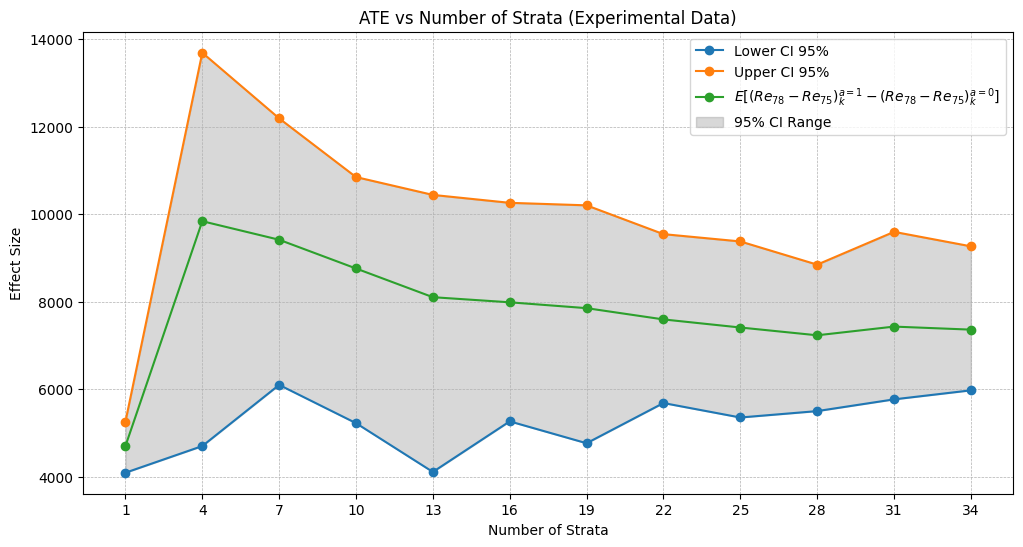

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(ci_df["num_strata"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["num_strata"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["num_strata"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1}_k - (Re_{78} - Re_{75})^{a=0}_k]$",
    marker="o",
)

plt.fill_between(
    ci_df["num_strata"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["num_strata"])
plt.xlabel("Number of Strata")
plt.ylabel("Effect Size")
plt.title("ATE vs Number of Strata (Experimental Data)")
plt.legend()
plt.show()

In [12]:
ci_df

,num_strata,mean,lower_ci,upper_ci
0,1,4704.455196,4096.363588,5261.269403
1,4,9839.499095,4705.070137,13686.488762
2,7,9415.867431,6101.654721,12187.307773
3,10,8759.953450,5228.536700,10847.353326
4,13,8104.447906,4113.933166,10439.904397
5,16,7987.558741,5268.923426,10259.261700
6,19,7854.034224,4769.369125,10201.753890
7,22,7596.761984,5687.456516,9544.244112
8,25,7412.188638,5357.381857,9377.552401
9,28,7234.377814,5503.367881,8847.570892


## Observational Data

In [13]:
propensity_probabilities = prop_probs(
    lalonde_obs,
    "treat",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
lalonde_obs = pd.merge(lalonde_obs, propensity_probabilities, on="id")

In [14]:
bootstrap_results = {}
num_strata_values = range(1, 35, 3)

for num_strata in num_strata_values:
    bootstrap_results[num_strata] = bootstrap_experiment(
        lalonde_obs,
        calculate_stratified_effects,
        num_exp=1,
        n=50,
        ci=95,
        prop_col="propensity",
        treatment_col="treat",
        outcome_col="re78_re75",
        num_strata=num_strata,
    )

Running experiments: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


In [15]:
data = []
for num_strata, ci_array in bootstrap_results.items():
    mean = ci_array[0, 0]
    lower = ci_array[0, 1]
    upper = ci_array[0, 2]
    data.append([num_strata, mean, lower, upper])

ci_df = pd.DataFrame(data, columns=["num_strata", "mean", "lower_ci", "upper_ci"])

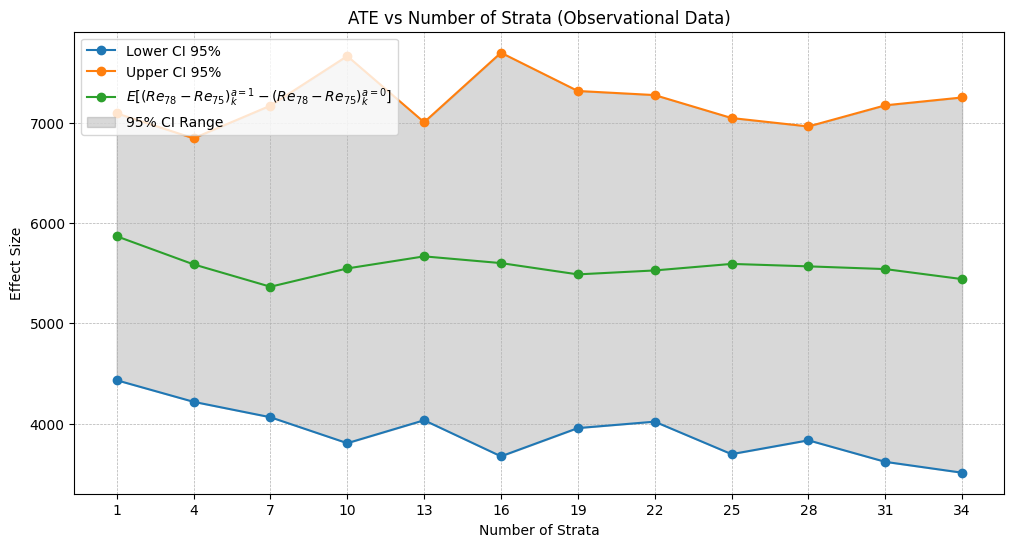

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(ci_df["num_strata"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["num_strata"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(
    ci_df["num_strata"],
    ci_df["mean"],
    label="$E[(Re_{78} - Re_{75})^{a=1}_k - (Re_{78} - Re_{75})^{a=0}_k]$",
    marker="o",
)

plt.fill_between(
    ci_df["num_strata"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["num_strata"])
plt.xlabel("Number of Strata")
plt.ylabel("Effect Size")
plt.title("ATE vs Number of Strata (Observational Data)")
plt.legend()
plt.show()

In [17]:
ci_df

,num_strata,mean,lower_ci,upper_ci
0,1,5867.506221,4433.001460,7092.409170
1,4,5587.591809,4218.014781,6843.734235
2,7,5364.638332,4064.378537,7168.934990
3,10,5546.921600,3805.883558,7663.018857
4,13,5667.274924,4034.443008,7003.741198
5,16,5600.196813,3674.854964,7696.358178
6,19,5487.700872,3956.238048,7315.208398
7,22,5527.068398,4020.247689,7274.395347
8,25,5592.072728,3696.509612,7045.747373
9,28,5567.689326,3834.452385,6961.809524


Our estimates here are less biased.